<a href="https://colab.research.google.com/github/kmc669/migrant_modeling/blob/main/migrant_modeling_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Migrant Death Location Modeling Using Maximum Entropy and Google Earth Engine
The following code has been adapted from the Google Earth Engine Species Distribution Modeling Tutorial by osgeokr, available at: https://developers.google.com/earth-engine/tutorials/community/species-distribution-modeling

In [71]:
import ee # Import google earth engine (GEE)

ee.Authenticate() # Authenticate

ee.Initialize(project = 'ee-kmc669') # Initialize GEE project

In [72]:
# Import neccessary libraries
import geemap

import geemap.colormaps as cm
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Import migrant decedent discovery locations to workspace

In [73]:
# Upload migrant death location data from Humane Borders from local machine
from google.colab import files

uploaded = files.upload()

Saving ogis_migrant_deaths (2).csv to ogis_migrant_deaths (2) (2).csv


In [77]:
# Import migrant death location data into pandas df
import io

df = pd.read_csv(io.BytesIO(uploaded['ogis_migrant_deaths (2) (2).csv']))

# Add year and date column to df
# Convert 'Reporting Date' column to datetime object & specify datetime format
df['Reporting Date'] = pd.to_datetime(df['Reporting Date'], format='%Y-%m-%d')
# Extract year, month, and day and add to new columns
df['Year'] = df['Reporting Date'].dt.year
df['Month'] = df['Reporting Date'].dt.month
df['Day'] = df['Reporting Date'].dt.day

print(type(df))
df.head(1) # Display first row of dataframe

<class 'pandas.core.frame.DataFrame'>


,ML Number,Name,Sex,Age,Reporting Date,Surface Management,Location,Location Precision,Corridor Code,Corridor,Cause of Death,OME Determined COD,Condition Code,Body Condition,Post Mortem Interval,State,County,Latitude,Longitude,UTM X,UTM Y,Year,Month,Day
0,00-00097,Unidentified,male,NaN,2000-01-10,Cocopah Indian Reservation,NaN,"physical description with directions, distance...",12,Yuma,Skeletal Remains,UNDETERMINED - MUMMIFIED AND SKELETAL REMAINS,4.0,Skeletonization w/ mummification,< 5 weeks,Arizona,YUMA,32.589668,-114.799807,143294,3612175,2000,1,10


In [80]:
# Convert dataframe to geodataframe
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs='EPSG:4326'
)

print(type(gdf)) # Check that conversion worked
gdf.head(1) #Display first row of dataframe

<class 'geopandas.geodataframe.GeoDataFrame'>


,ML Number,Name,Sex,Age,Reporting Date,Surface Management,Location,Location Precision,Corridor Code,Corridor,Cause of Death,OME Determined COD,Condition Code,Body Condition,Post Mortem Interval,State,County,Latitude,Longitude,UTM X,UTM Y,Year,Month,Day,geometry
0,00-00097,Unidentified,male,NaN,2000-01-10,Cocopah Indian Reservation,NaN,"physical description with directions, distance...",12,Yuma,Skeletal Remains,UNDETERMINED - MUMMIFIED AND SKELETAL REMAINS,4.0,Skeletonization w/ mummification,< 5 weeks,Arizona,YUMA,32.589668,-114.799807,143294,3612175,2000,1,10,POINT (-114.79981 32.58967)


### Constrain data to boundary of Cabeza Prieta National Wildlife Refuge

In [107]:
# Import study area boundary (Cabeza Prieta Wildlife Refuge)
uploaded = files.upload()

Saving cabeza_boundary.geojson to cabeza_boundary (2).geojson


In [108]:
# Define Area of Interest (AOI)

geojson_bytes = uploaded['cabeza_boundary (2).geojson'] # Store uploaded GeoJSON
geojson_string = geojson_bytes.decode('utf-8 ') # Transform bytes > string

import json
geojson_data = json.loads(geojson_string) # Parse GeoJSON to Python dictionary

from shapely.geometry import shape
aoi_geometry_shapely = shape(geojson_data['features'][0]['geometry']) # Convert GeoJSON to shapely geometry

AOI = ee.FeatureCollection(geojson_data) # Store aoi as ee feature
aoi_geometry_ee = AOI.geometry() # Get aoi geometry

In [109]:
# Constrain data to AOI
gdf = gdf[gdf.within(aoi_geometry_shapely)]

### Plot Yearly and Monthly Distribution Heat Map

In [110]:
# Plot yearly and monthly distribution heat maps
def plot_heatmap(gdf, h_size=25):

  statistics = gdf.groupby(["Month", "Year"]).size().unstack(fill_value=0)

  # Heatmaps
  plt.figure(figsize=(h_size, h_size - 6))
  heatmap = plt.imshow(
      statistics.values, cmap="YlOrBr", origin="upper", aspect="auto"
  )

  # Display values above each pixel
  for i in range(len(statistics.index)):
    for j in range(len(statistics.columns)):
        plt.text(
          j, i, statistics.values[i, j], ha="center", va="center", color="black"
      )

  plt.colorbar(heatmap, label="Count")
  plt.title("Monthly Species Count by Year")
  plt.xlabel("Year")
  plt.ylabel("Month")
  plt.xticks(range(len(statistics.columns)), statistics.columns)
  plt.yticks(range(len(statistics.index)), statistics.index)
  plt.tight_layout()
  plt.savefig("heatmap_plot.png")
  plt.show()

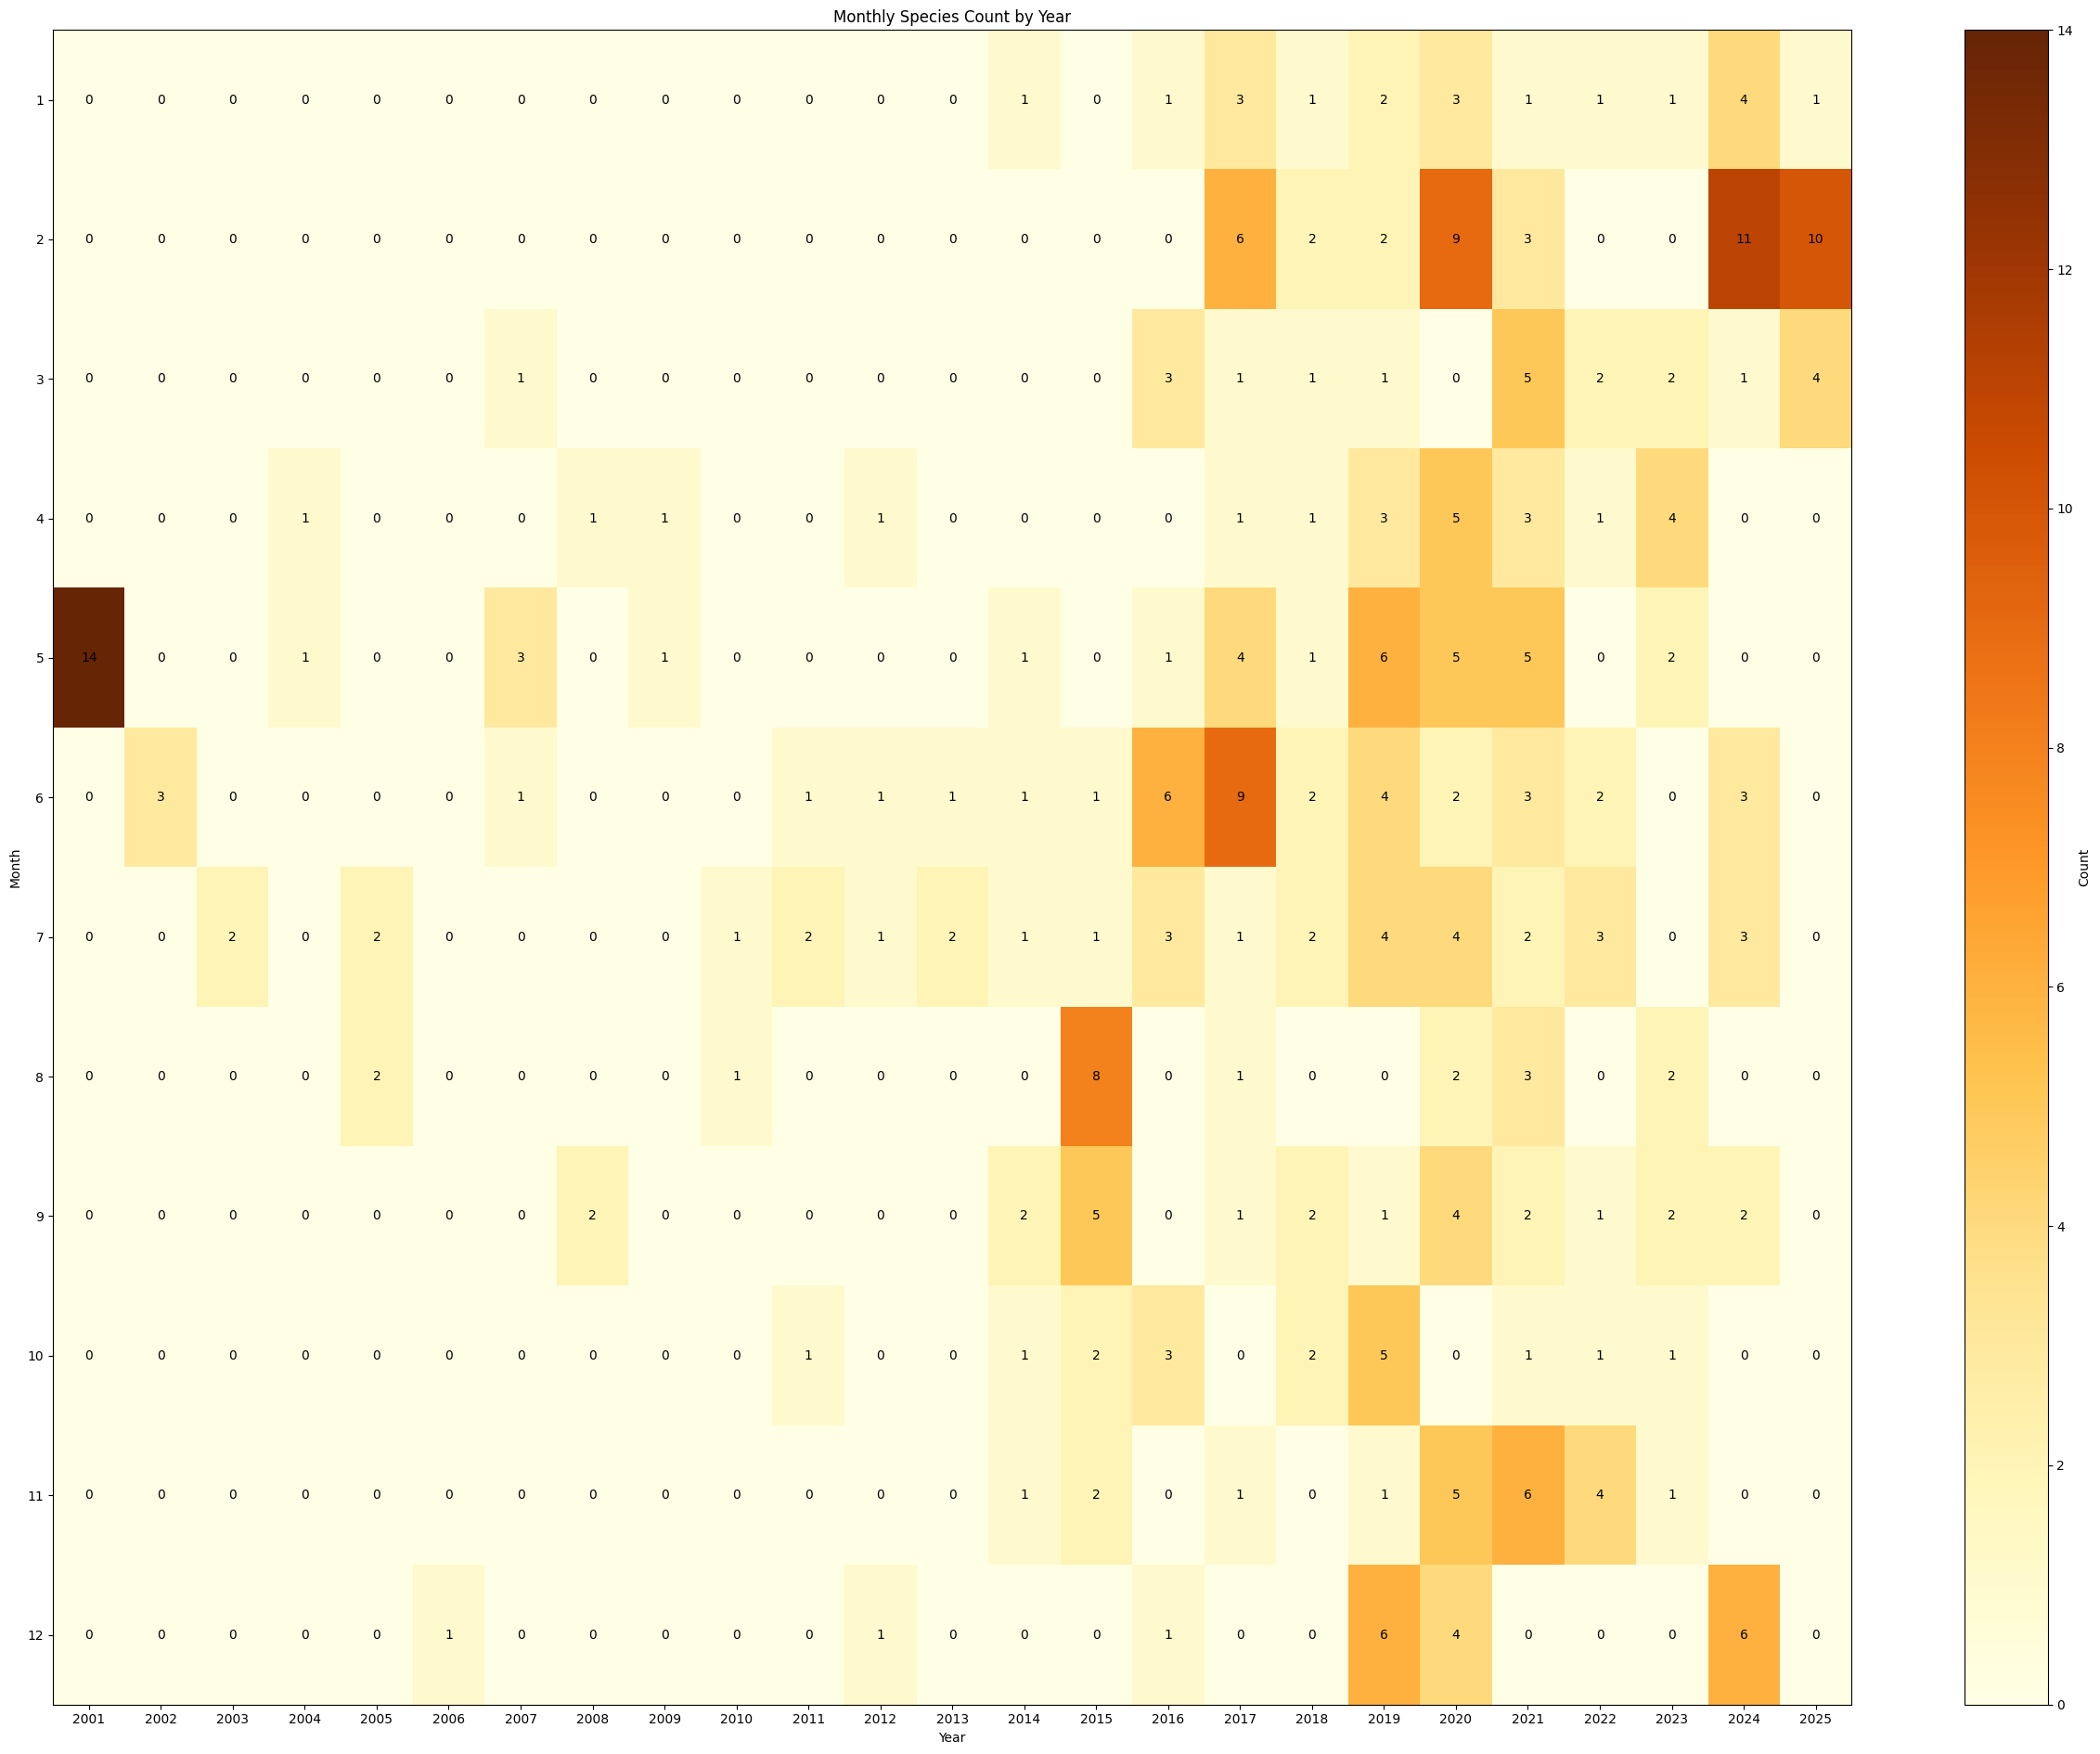

In [111]:
plot_heatmap(gdf)

In [112]:
# Convert gdf to earth engine object
data_raw = geemap.geopandas_to_ee(gdf)

### Define Grain Size
*Defining a grain size for the project will set our spatial resolution globally, i.e. for all pixels across all variables*

In [113]:
# Define global spatial resolution settings (meters)
grain_size = 10

#### A note on my selected grain size:
Most species distribution models (SDM) will rely on lower resolutions (e.g., 1000m), since this technique is used over larger territories like countries and a "suitable environment" could be hundreds of meters in diameter. For the purpose of modeling migrant death locations in Cabeza Prieta Wildlife Refuge (Cabeza), the study area is much smaller and the "sites" are also smaller. A single location with human remains could be distributed across the landscape by animal activity, but generally will be reported as a single individual if bone is within a 10m diameter area.

### Remove duplicate points:
Some locations will have more than one discovery of human remains within a single 10m grid cell. This will introduce geographic sampling bias if not corrected. The following code will remove duplicate points such that each 10m grid cell contains a maximum of one discovery.

In [114]:
def remove_duplicates(data, grain_size):
  random_raster = ee.Image.random().reproject("EPSG:4326", None, grain_size)
  rand_point_vals = random_raster.sampleRegions(
      collection=ee.FeatureCollection(data), geometries=True
  )
  return rand_point_vals.distinct("random")

data = remove_duplicates(data_raw, grain_size)

print("Original data siz:", data_raw.size().getInfo())
print("Final data size:", data.size().getInfo())

Original data siz: 323
Final data size: 315


### Visualizing sampling bias before (blue) and after (red) removing duplicates within grid

In [115]:
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

# Add the random raster layer
random_raster = ee.Image.random().reproject("EPSG:4326", None, grain_size)
Map.addLayer(
    random_raster,
    {"min": 0, "max": 1, "palette": ["black", "white"], "opacity": 0.5},
    "Random Raster",
)

Map.addLayer(data_raw, {"color": "blue"}, "Original Data") # Add the original data layer

Map.addLayer(data, {"color": "red"}, "Final Data") # Add the final data layer


outline = ee.Image().byte().paint(featureCollection=aoi_geometry_ee, color=1, width=3) # Define outline
Map.addLayer(outline, {'palette': 'FF0000'}, "AOI") # Add AOI outline to map
Map.centerObject(aoi_geometry_ee, 6) # Center map on AOI
Map

Map(center=[32.26618327312111, -113.39236291258105], controls=(WidgetControl(options=['position', 'transparent…

## Adding environmental variables
I will focus on slope, elevation, NDVI, distance from the border, distance from main roads and surface temperature for the predictor variables.

*Note: other potential predictors like ruggedness and wetness index were not included due to their correlation to the other predictors.*


In [ ]:
# Add elevation
elev = ee.ImageCollection().filterBounds(aoi_geometry_ee).reproject('EPSG:4326', null, grain_size).rename('Elevation')

In [118]:
# Add surface temperature
temp = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi_geometry_ee)
temp = temp.select('ST_B10') # Select temperature band

# Filter to date range, average to median, and restrict to aoi
temp = temp.filterDate('2021-11-01', '2025-05-01').median().clip(aoi_geometry_ee)

# Reproject
temp = temp.reproject('EPSG:4326', None, grain_size).rename('Temperature')

# Define map visualization parameters
temp_vis = {
    'min': 290,
    'max': 310,
    'palette': ['blue', 'white', 'red']
}

# Add layer to map
Map.addLayer(temp, temp_vis, 'Median Surface Temperature')
Map

Map(bottom=52919.0, center=[33.17664043594348, -113.46679687500001], controls=(WidgetControl(options=['positio…